# Win probabilty using Random Forest Classifier for each Team

In my analysis, I used a Random Forest Classifier to predict the win probability for each team. For this, I trained a separate model for each team using their inning data.

I then asked the model to identify the 10 most important features that it used for training. From this, I observed that the total runs scored by the team and the team’s strike rate were significant features in the model’s predictions.

This suggests that the total runs and the strike rate of a team play a crucial role in determining the outcome of a match. Therefore, teams with higher total runs and strike rates are more likely to win according to the model.

Accuracy for Australia : 0.6842105263157895


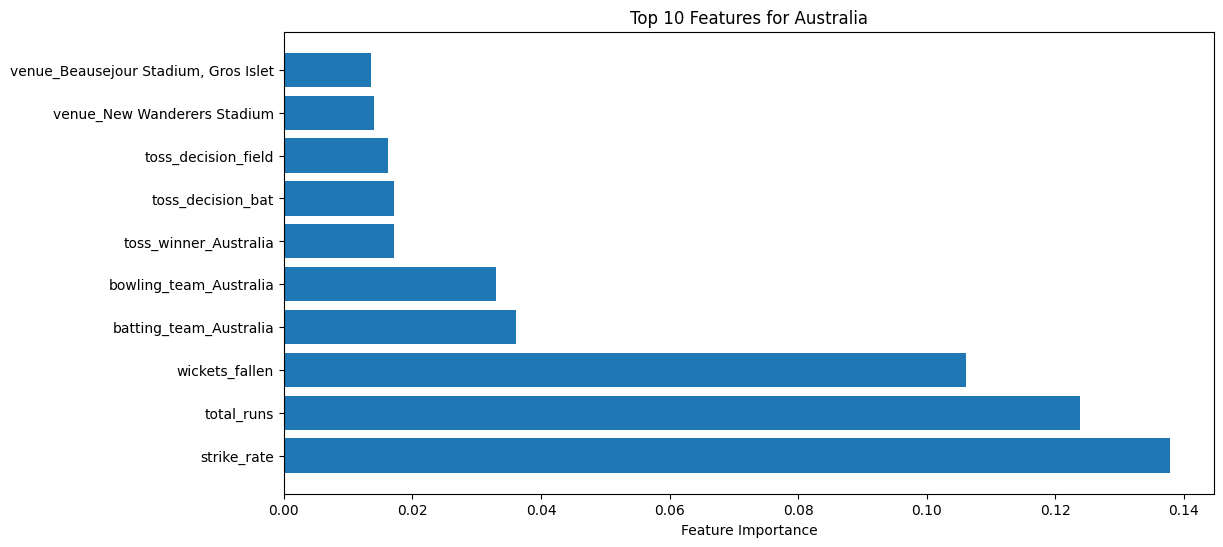

Win Probability for Australia : [0.53 0.95 0.37 0.85 0.55 0.36 0.2  0.51 0.16 0.96 0.85 0.75 0.59 0.7
 0.34 0.26 0.19 0.53 0.56 0.87 0.72 0.65 0.74 0.25 0.12 0.54 0.86 0.38
 0.58 0.34 0.29 0.42 0.64 0.36 0.25 0.21 0.78 0.7  0.47 0.59 0.36 0.74
 0.31 0.29 0.76 0.27 0.53 0.71 0.34 0.43 0.51 0.18 0.81 0.5  0.47 0.24
 0.36 0.78 0.63 0.39 0.39 0.57 0.55 0.19 0.78 0.25 0.65 0.78 0.47 0.51
 0.73 0.52 0.38 0.39 0.4  0.07]


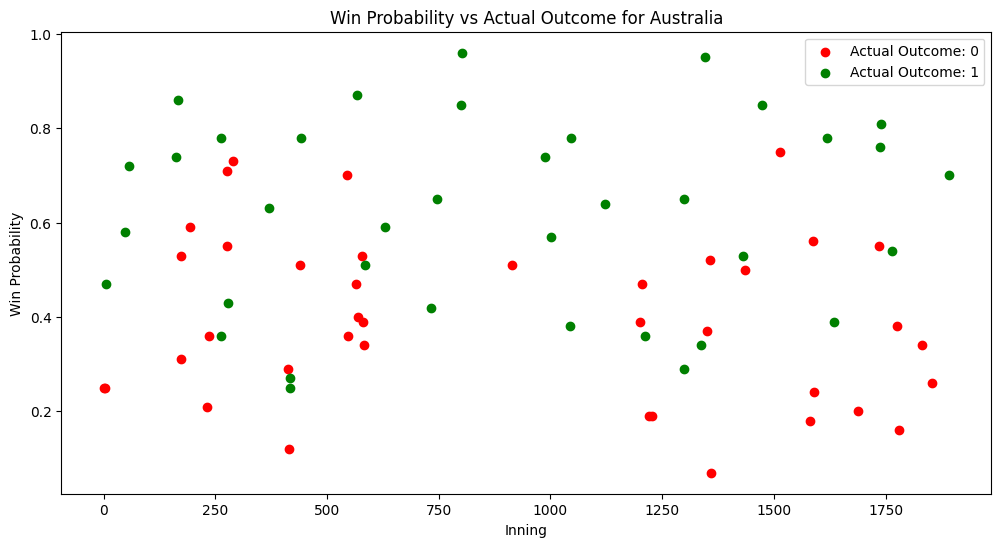

Accuracy for Sri Lanka : 0.7222222222222222


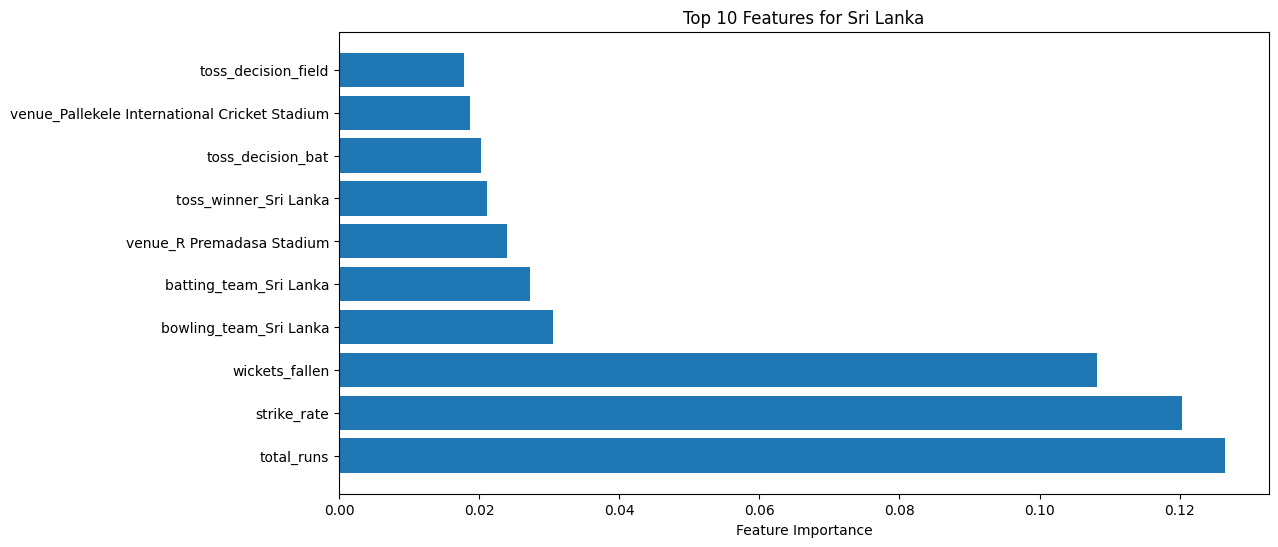

Win Probability for Sri Lanka : [0.53 0.16 0.6  0.38 0.3  0.31 0.08 0.64 0.59 0.51 0.1  0.2  0.52 0.38
 0.25 0.65 0.08 0.52 0.12 0.32 0.05 0.57 0.12 0.07 0.56 0.16 0.39 0.38
 0.68 0.56 0.56 0.49 0.1  0.18 0.48 0.45 0.13 0.59 0.42 0.53 0.55 0.4
 0.74 0.12 0.53 0.51 0.2  0.1  0.24 0.1  0.56 0.8  0.72 0.49 0.21 0.51
 0.47 0.46 0.17 0.08 0.52 0.12 0.59 0.19 0.65 0.63 0.33 0.29 0.71 0.42
 0.52 0.3 ]


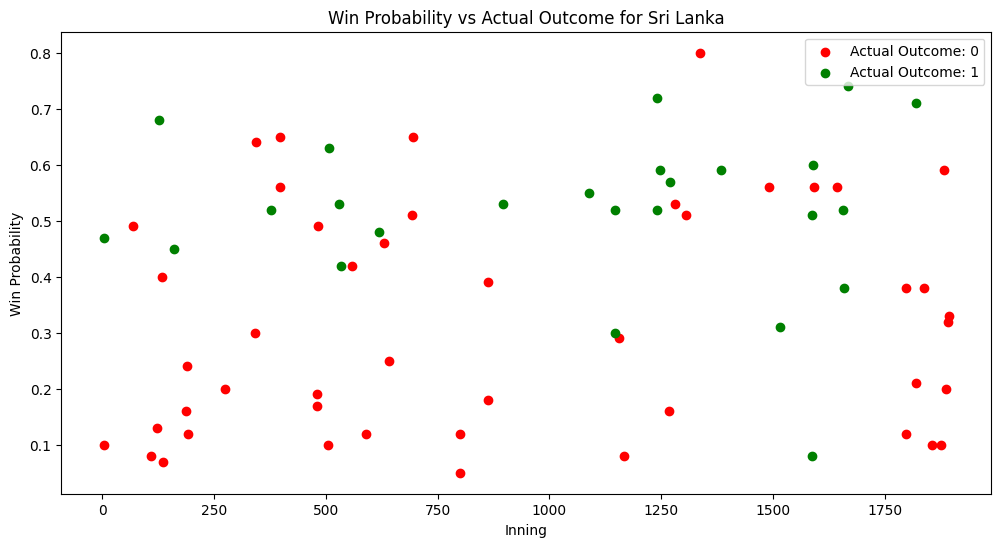

Accuracy for India : 0.7647058823529411


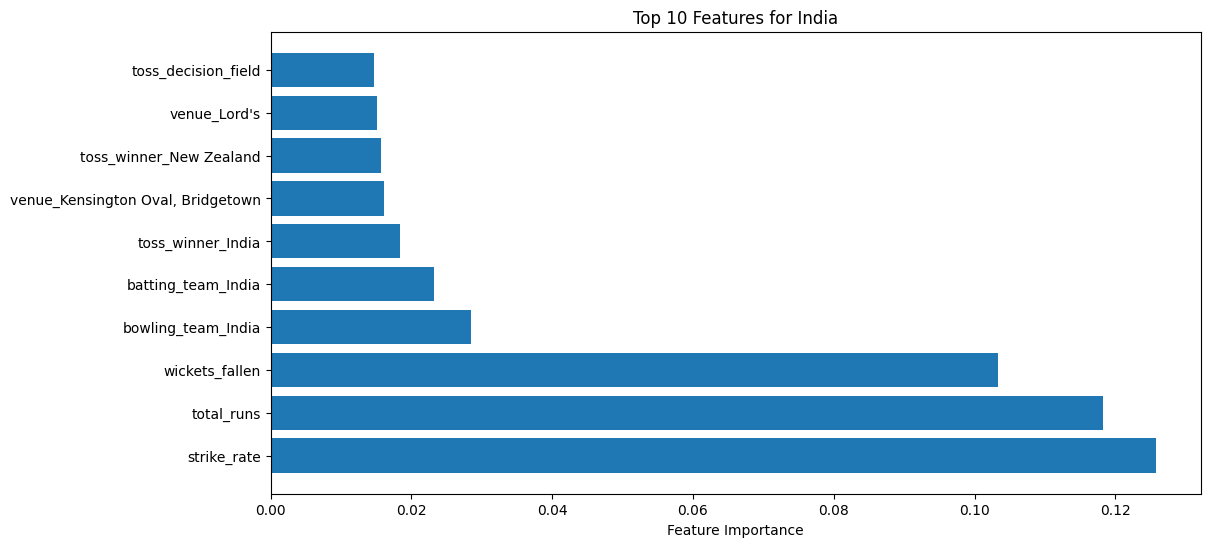

Win Probability for India : [0.13 0.42 0.18 0.69 0.74 0.91 0.39 0.74 0.55 0.83 0.54 0.62 0.56 0.84
 0.89 0.88 0.32 0.7  0.59 0.74 0.66 0.37 0.87 0.24 0.79 0.29 0.91 0.51
 0.62 0.56 0.79 0.72 0.76 0.75 0.51 0.93 0.54 0.25 0.81 0.69 0.87 0.64
 0.85 0.28 0.88 0.91 0.76 0.87 0.89 0.89 0.92 0.6  0.89 0.66 0.83 0.8
 0.2  0.3  0.41 0.91 0.86 0.26 0.75 0.59 0.71 0.74 0.66 0.63 0.49 0.9
 0.45 0.58 0.77 0.71 0.42 0.69 0.62 0.43 0.46 0.69 0.87 0.75 0.77 0.28
 0.22]


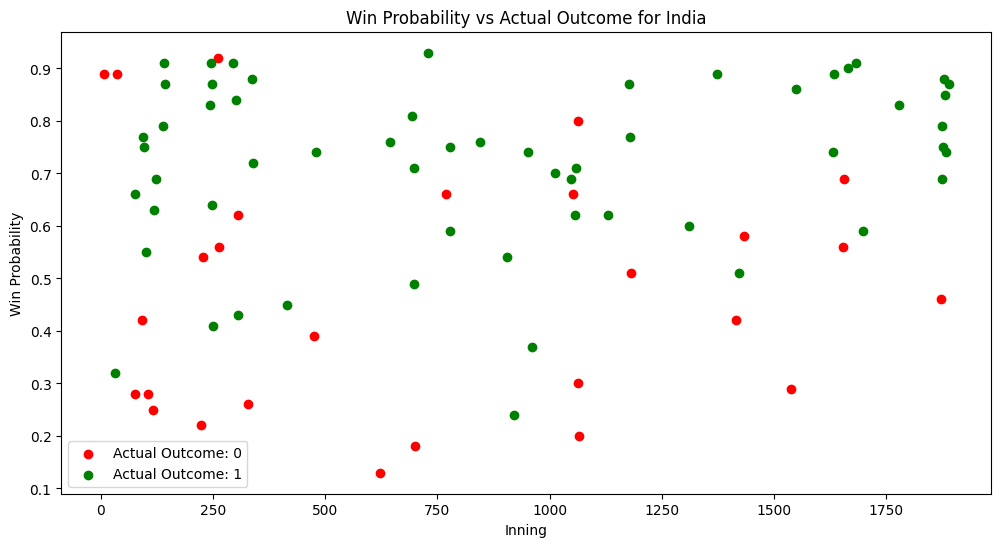

Accuracy for Zimbabwe : 0.7894736842105263


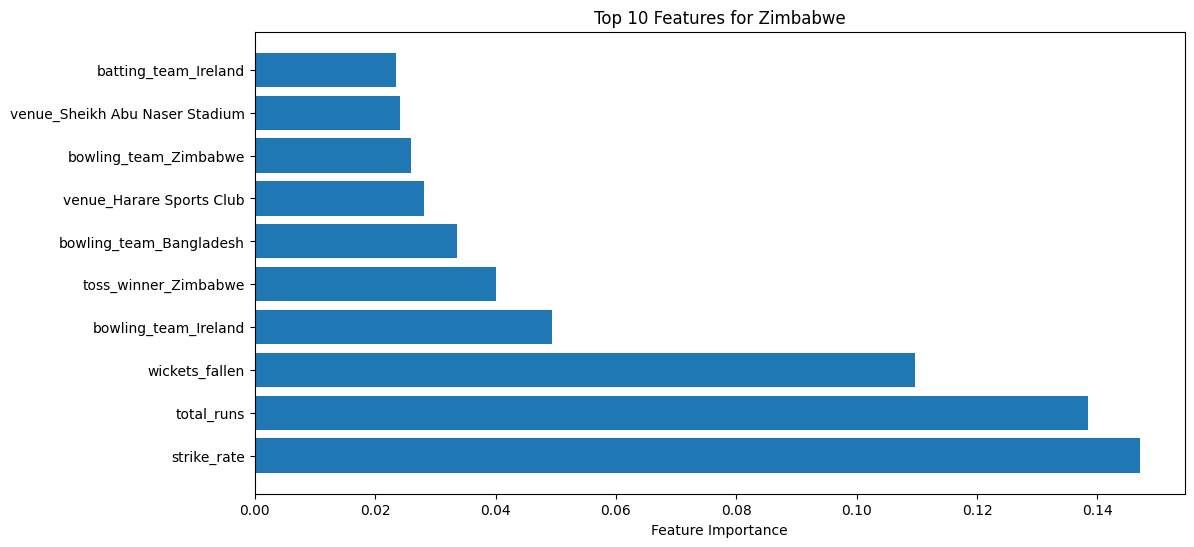

Win Probability for Zimbabwe : [0.18 0.05 0.1  0.13 0.58 0.16 0.08 0.08 0.16 0.04 0.34 0.2  0.01 0.26
 0.08 0.13 0.28 0.07 0.41 0.05 0.55 0.19 0.02 0.05 0.09 0.44 0.2  0.22
 0.47 0.67 0.17 0.12 0.56 0.54 0.29 0.47 0.6  0.01]


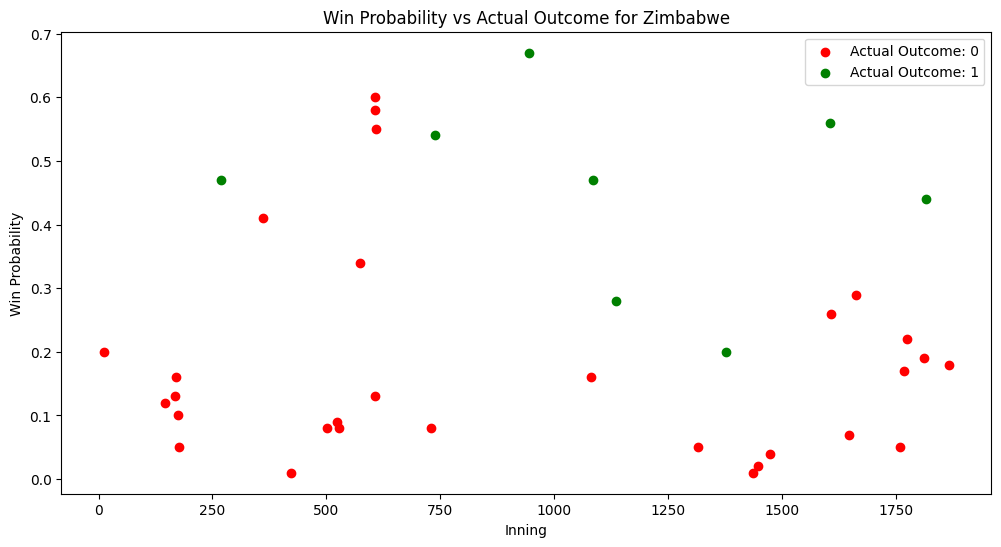

Accuracy for Bangladesh : 0.6964285714285714


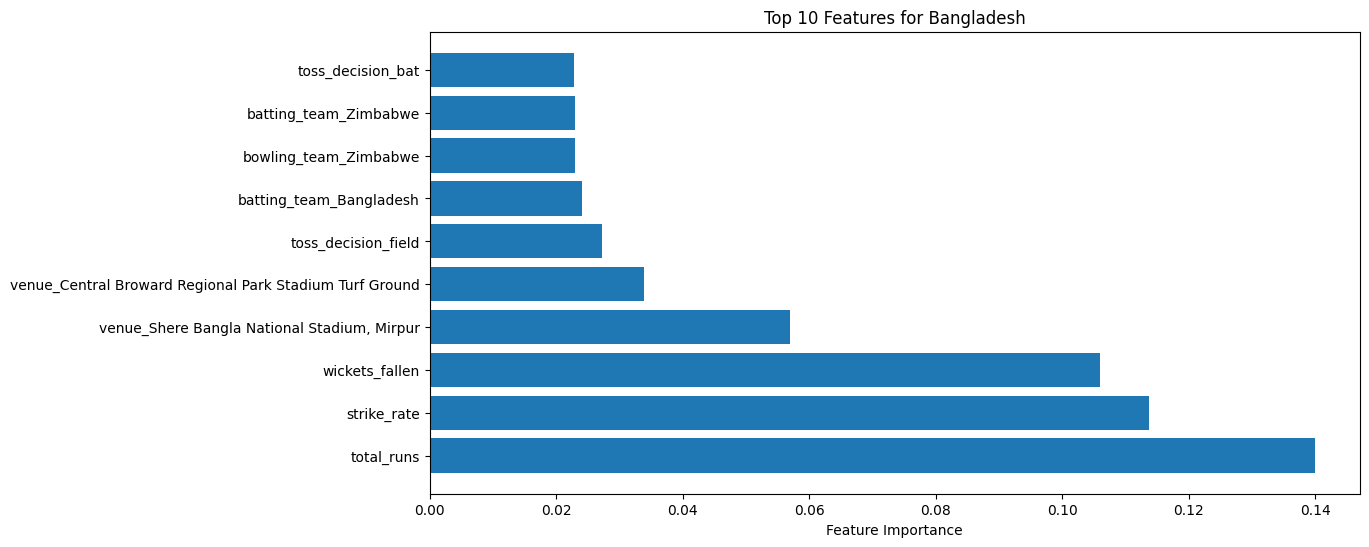

Win Probability for Bangladesh : [0.25 0.49 0.11 0.08 0.13 0.49 0.61 0.27 0.31 0.32 0.09 0.14 0.31 0.07
 0.21 0.11 0.13 0.2  0.23 0.47 0.62 0.18 0.3  0.6  0.11 0.03 0.34 0.6
 0.39 0.46 0.21 0.78 0.3  0.45 0.46 0.17 0.5  0.13 0.09 0.1  0.46 0.19
 0.82 0.45 0.33 0.18 0.05 0.36 0.28 0.36 0.65 0.55 0.17 0.36 0.74 0.46]


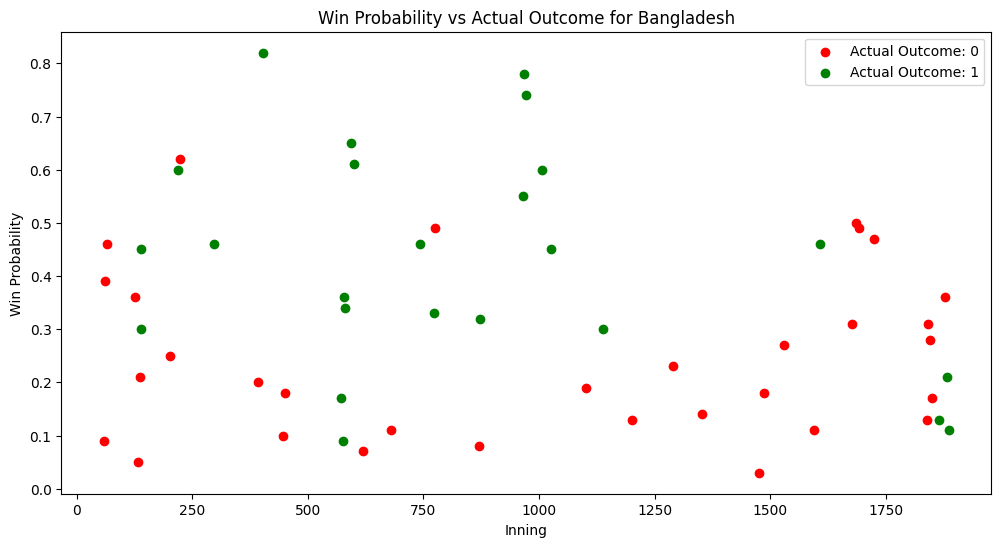

Accuracy for New Zealand : 0.7777777777777778


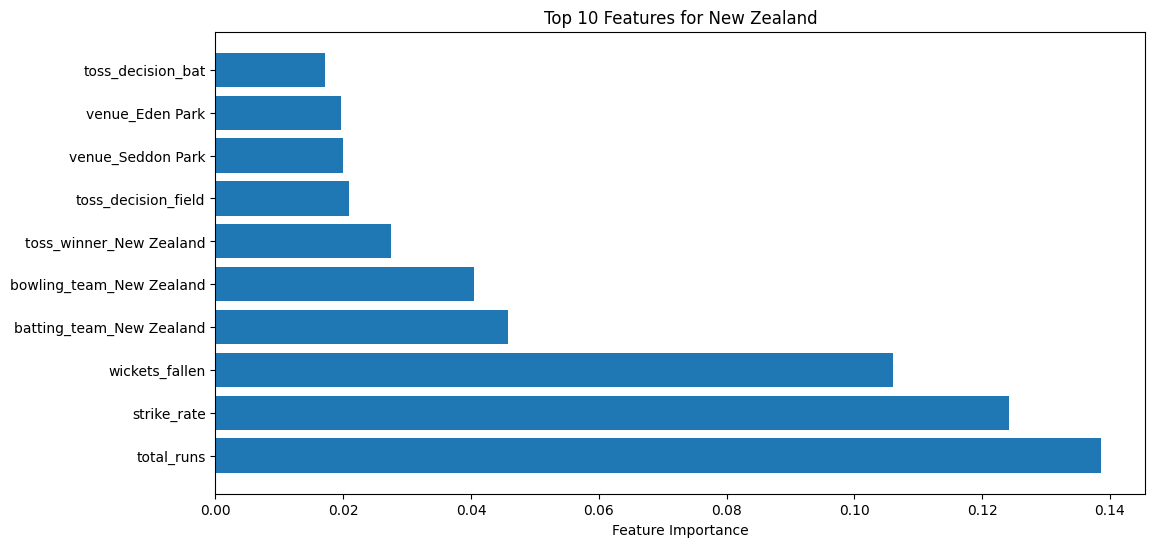

Win Probability for New Zealand : [0.33 0.2  0.62 0.26 0.7  0.16 0.83 0.77 0.65 0.24 0.51 0.7  0.75 0.51
 0.06 0.38 0.12 0.24 0.34 0.17 0.36 0.26 0.06 0.6  0.26 0.26 0.36 0.41
 0.58 0.78 0.7  0.36 0.71 0.48 0.27 0.16 0.32 0.46 0.72 0.63 0.59 0.25
 0.13 0.68 0.72 0.68 0.29 0.89 0.37 0.32 0.53 0.73 0.38 0.1  0.83 0.09
 0.85 0.09 0.48 0.27 0.25 0.33 0.25 0.31 0.26 0.57 0.72 0.54 0.29 0.84
 0.71 0.27 0.64 0.38 0.94 0.96 0.08 0.66 0.36 0.36 0.7 ]


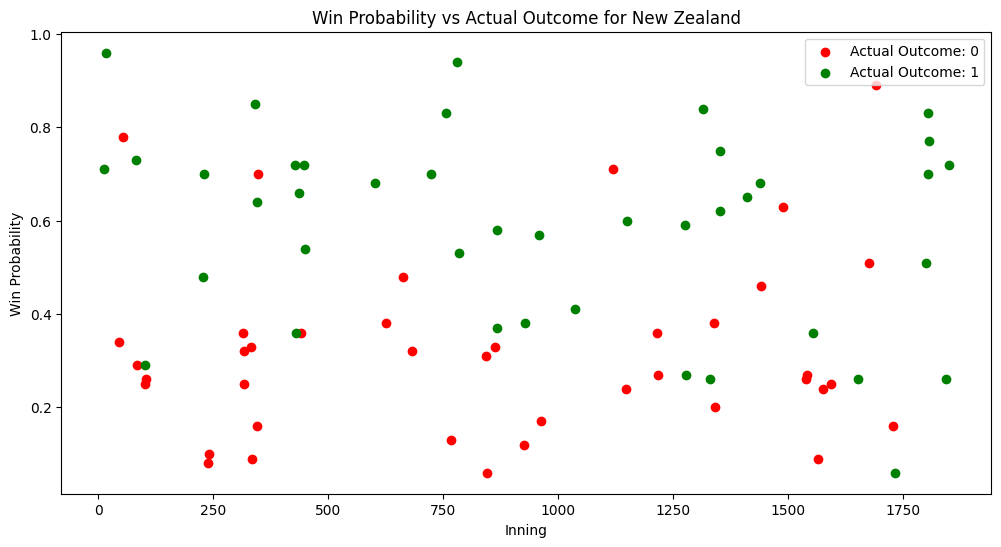

Accuracy for South Africa : 0.7313432835820896


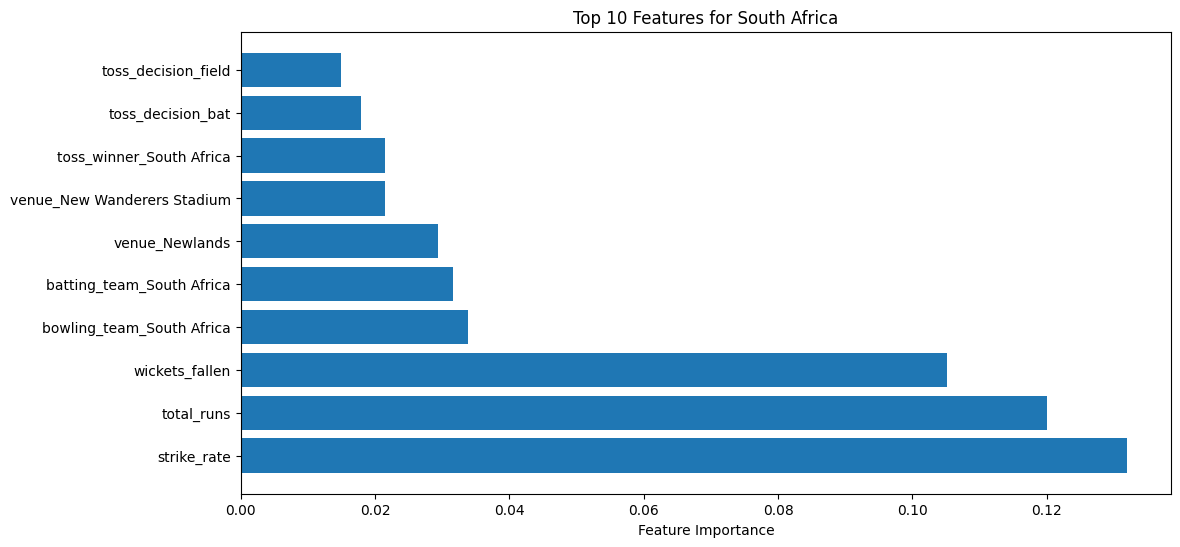

Win Probability for South Africa : [0.32 0.53 0.61 0.71 0.62 0.25 0.27 0.71 0.75 0.53 0.97 0.89 0.81 0.45
 0.91 0.66 0.74 0.17 0.69 0.57 0.82 0.57 0.11 0.39 0.56 0.64 0.47 0.28
 0.72 0.62 0.44 0.64 0.55 0.83 0.44 0.1  0.45 0.86 0.19 0.27 0.88 0.54
 0.32 0.6  0.28 0.43 0.52 0.35 0.61 0.55 0.95 0.48 0.53 0.29 0.58 0.3
 0.6  0.45 0.06 0.92 0.7  0.31 0.76 0.73 0.9  0.6  0.3 ]


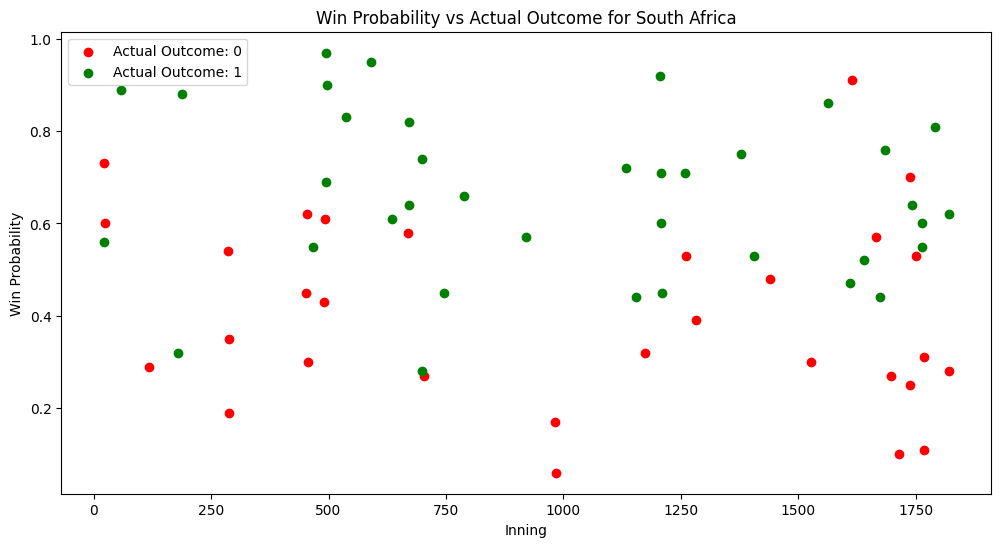

Accuracy for England : 0.7777777777777778


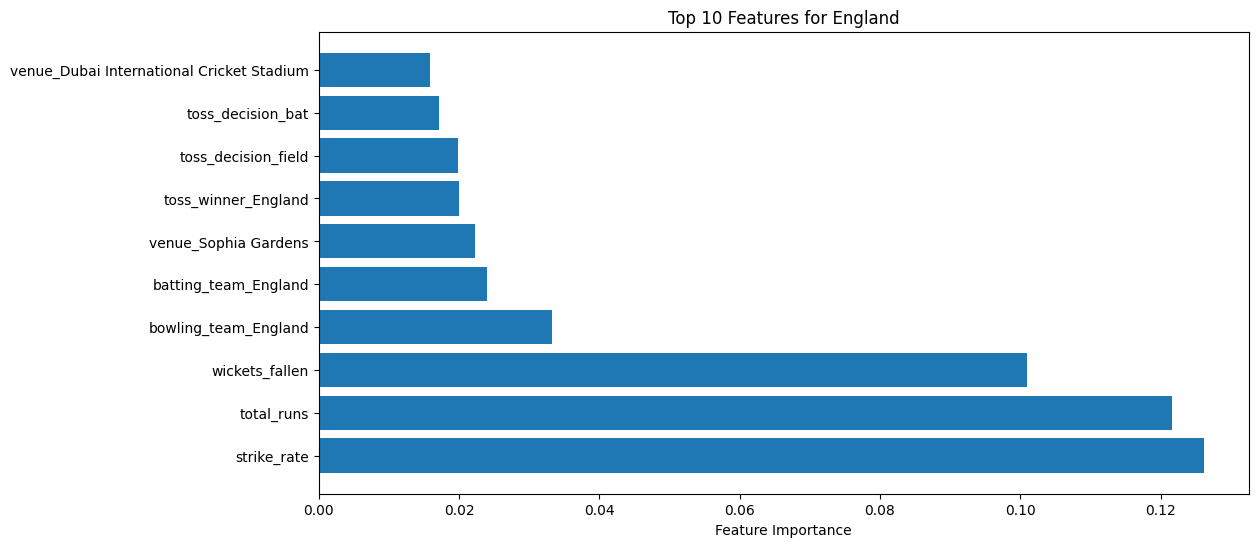

Win Probability for England : [0.22 0.62 0.3  0.62 0.39 0.8  0.36 0.52 0.79 0.87 0.26 0.75 0.4  0.7
 0.51 0.14 0.28 0.57 0.42 0.77 0.23 0.35 0.89 0.85 0.76 0.62 0.6  0.44
 0.17 0.53 0.49 0.69 0.66 0.53 0.58 0.62 0.73 0.24 0.6  0.84 0.12 0.68
 0.57 0.63 0.66 0.56 0.39 0.79 0.54 0.62 0.68 0.67 0.53 0.77 0.38 0.38
 0.09 0.51 0.52 0.76 0.48 0.66 0.64 0.75 0.73 0.57 0.56 0.38 0.41 0.92
 0.18 0.32]


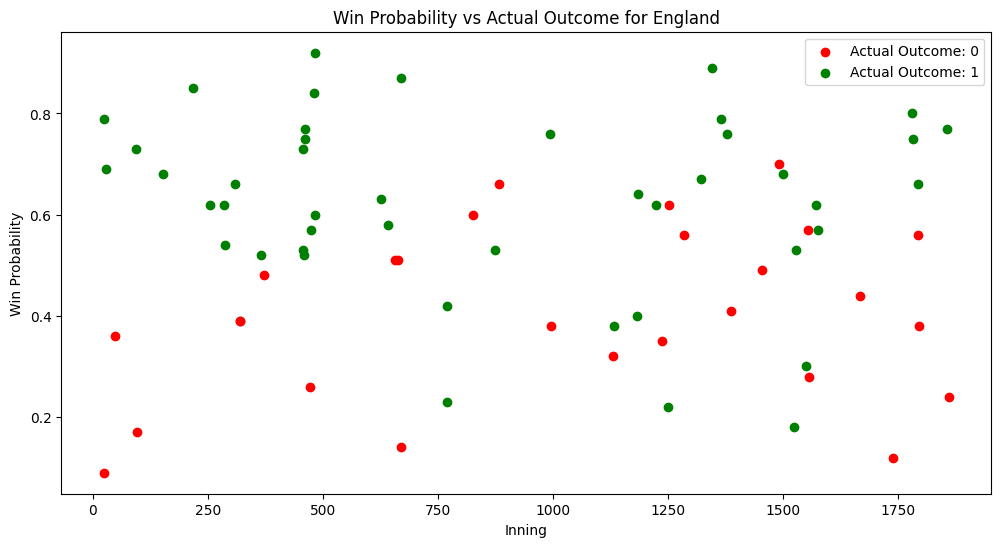

Accuracy for West Indies : 0.7671232876712328


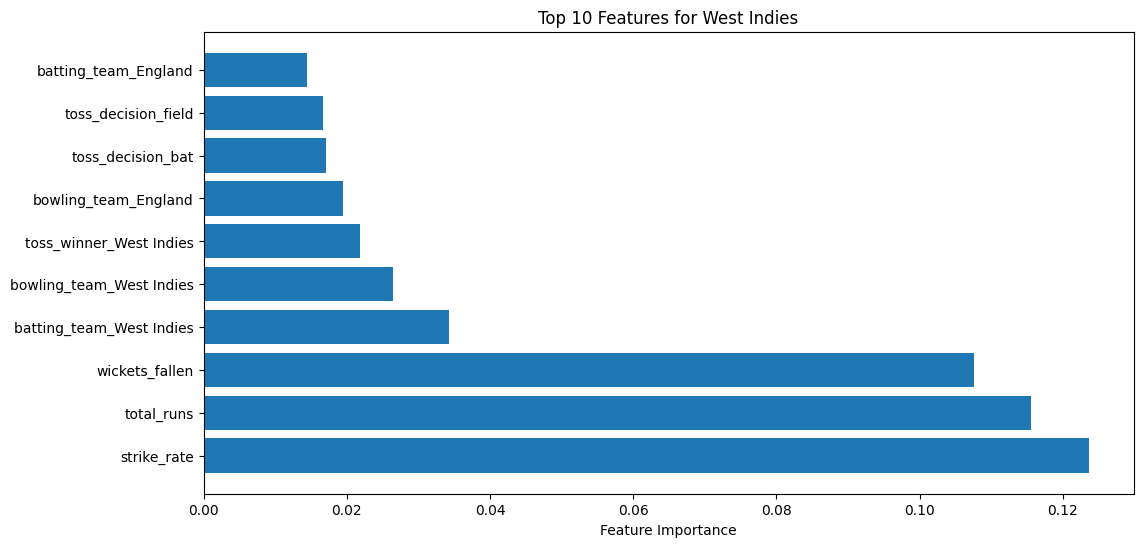

Win Probability for West Indies : [0.15 0.72 0.17 0.58 0.55 0.51 0.52 0.55 0.29 0.22 0.24 0.58 0.09 0.26
 0.39 0.36 0.32 0.49 0.55 0.34 0.09 0.25 0.4  0.1  0.54 0.79 0.5  0.25
 0.33 0.36 0.15 0.22 0.64 0.36 0.7  0.4  0.22 0.12 0.45 0.21 0.17 0.54
 0.16 0.65 0.48 0.28 0.75 0.28 0.17 0.09 0.61 0.53 0.3  0.52 0.41 0.53
 0.16 0.57 0.31 0.38 0.43 0.48 0.61 0.29 0.19 0.21 0.32 0.4  0.35 0.33
 0.2  0.46 0.68]


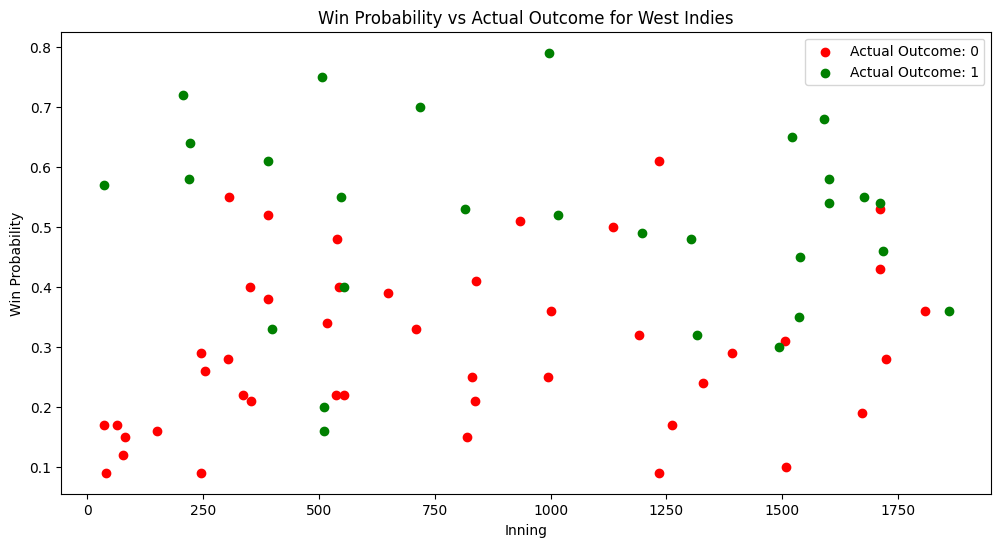

Accuracy for Pakistan : 0.8095238095238095


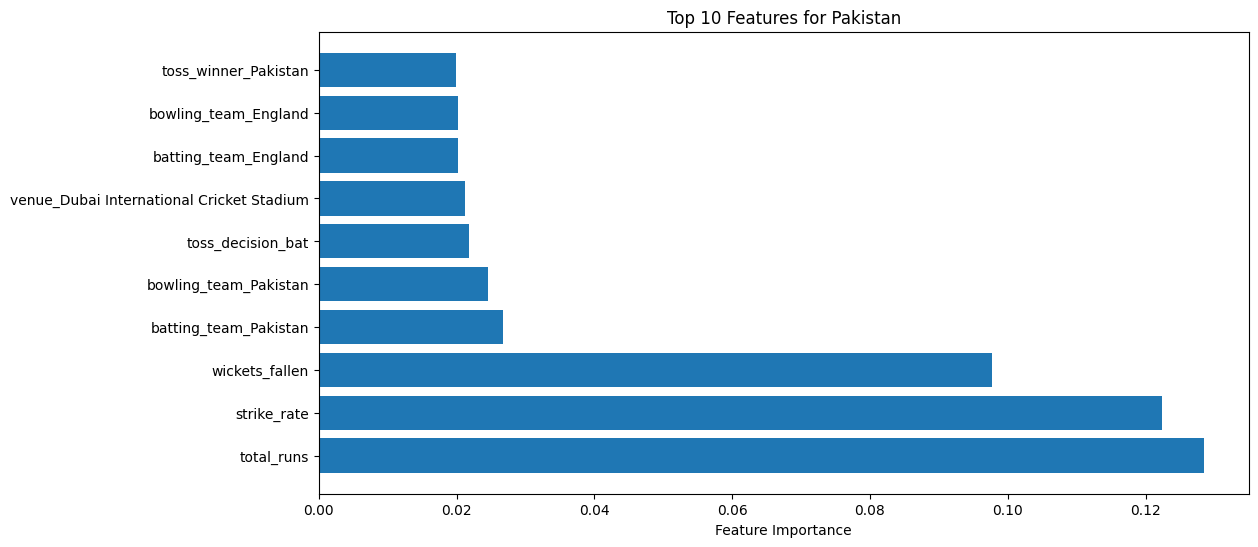

Win Probability for Pakistan : [0.58 0.62 0.34 0.86 0.61 0.75 0.16 0.72 0.87 0.4  0.25 0.55 0.53 0.17
 0.56 0.72 0.86 0.76 0.35 0.87 0.37 0.74 0.18 0.64 0.48 0.7  0.73 0.52
 0.61 0.95 0.2  0.72 0.23 0.49 0.61 0.27 0.68 0.56 0.52 0.88 0.75 0.45
 0.15 0.7  0.18 0.27 0.56 0.59 0.52 0.25 0.93 0.88 0.86 0.83 0.17 0.1
 0.45 0.54 0.51 0.94 0.91 0.05 0.68 0.9  0.74 0.26 0.62 0.47 0.36 0.72
 0.8  0.24 0.8  0.76 0.54 0.68 0.54 0.56 0.56 0.08 0.74 0.56 0.69 0.75]


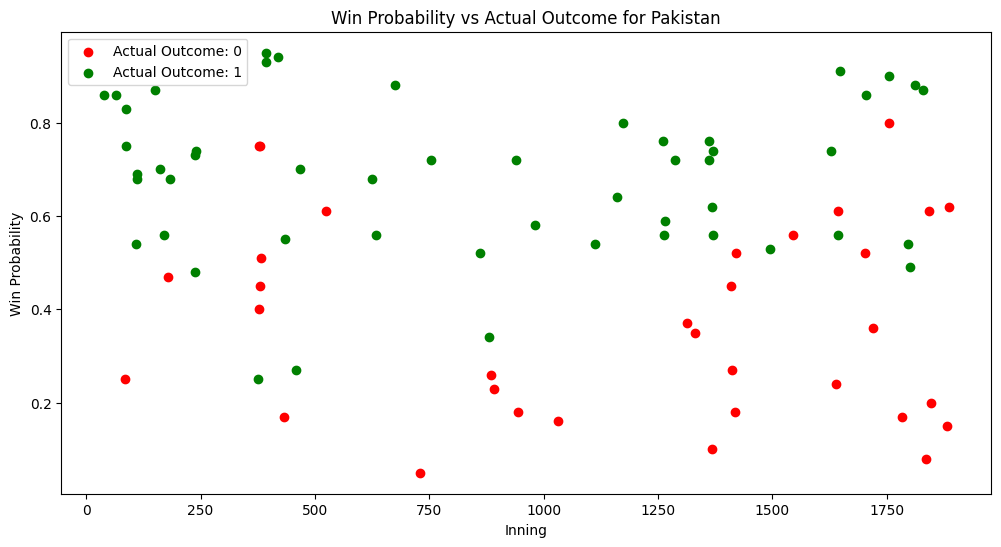

Accuracy for Afghanistan : 0.76


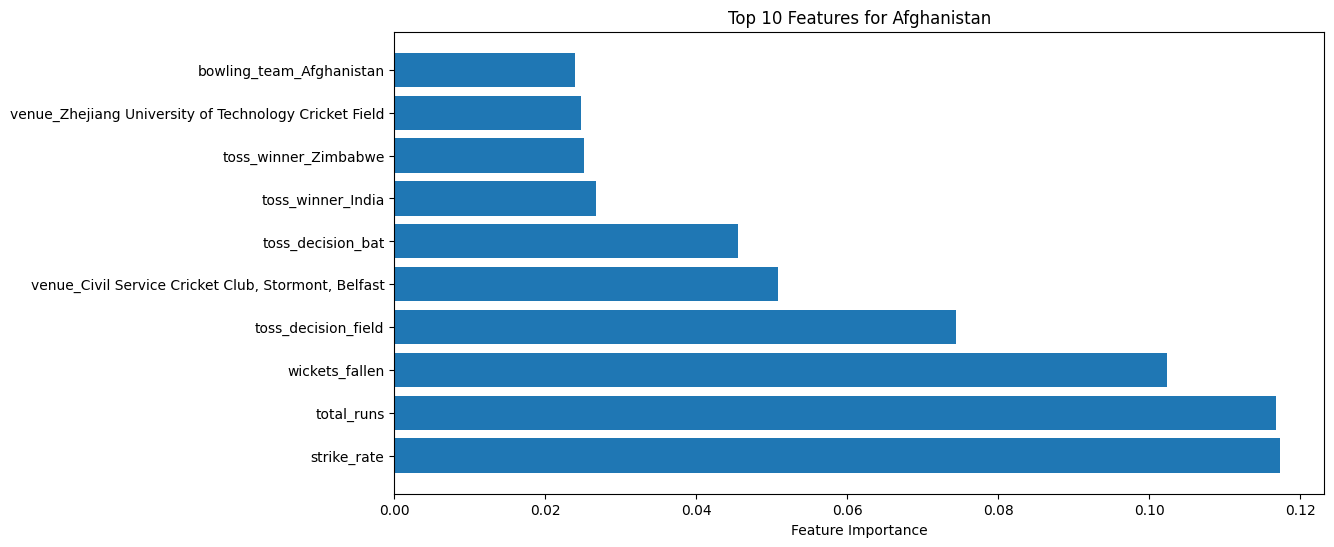

Win Probability for Afghanistan : [0.64 0.75 0.84 0.82 0.36 0.74 0.51 0.75 0.78 0.33 0.64 0.19 0.84 0.06
 0.5  0.56 0.47 0.11 0.57 0.3  0.65 0.8  0.38 0.78 0.5 ]


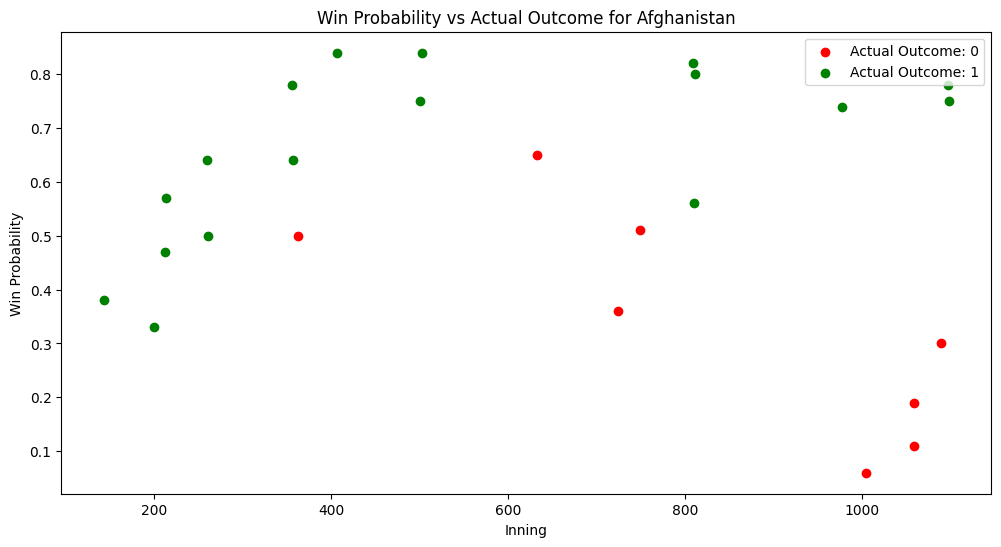

Accuracy for Ireland : 0.8571428571428571


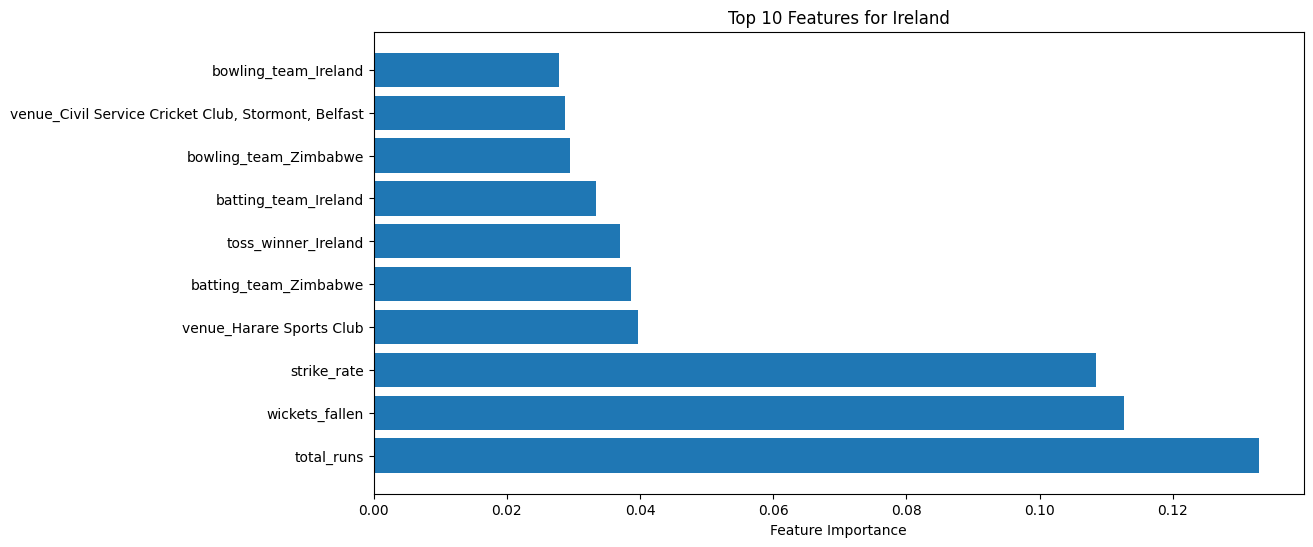

Win Probability for Ireland : [0.48 0.15 0.2  0.24 0.54 0.09 0.39 0.26 0.3  0.26 0.28 0.16 0.16 0.34
 0.13 0.03 0.21 0.42 0.58 0.34 0.1  0.21 0.43 0.2  0.06 0.15 0.18 0.11]


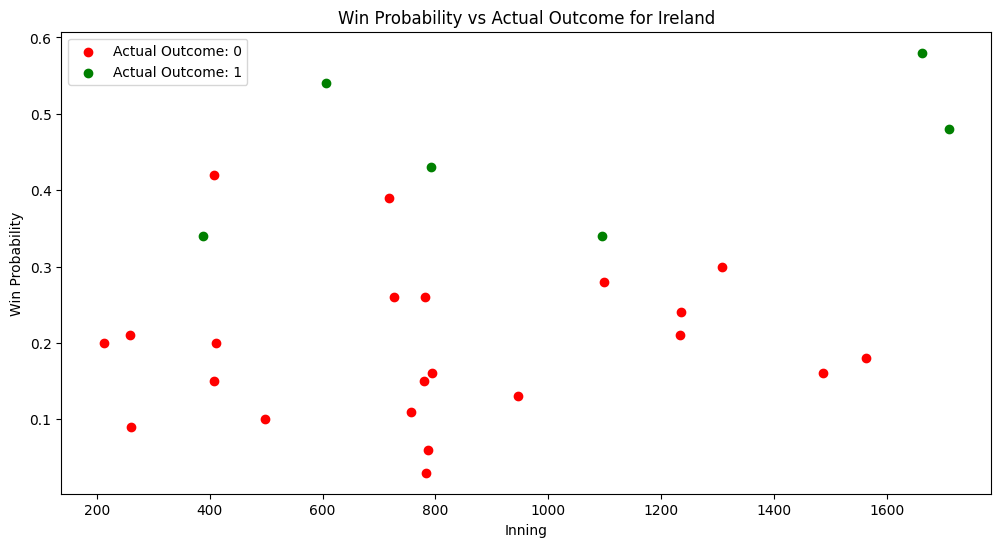

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Used only selected columns 
df = pd.read_csv("../Data/selected_data/merged_data.csv", usecols=['Unnamed: 0', 'batter', 'total_runs_delivery', 'balls_faced', 'winning_team', 'venue', 'toss_decision', 'toss_winner', 'batting_team', 'bowling_team', 'wickets_fallen'])

# Identify the boundaries of each inning
inning_boundaries_indices = df[df['Unnamed: 0'] == 0].index.tolist()
inning_boundaries_indices.append(len(df))  # Add the last index

# Function to process each inning and extract features
def process_inning(df_inning):
    inning_features = {}
    inning_features['total_runs'] = df_inning['total_runs_delivery'].sum()
    inning_features['wickets_fallen'] = df_inning['wickets_fallen'].max()
    inning_features['strike_rate'] = df_inning['total_runs_delivery'].sum()*100/len(df_inning)
    inning_features['venue'] = df_inning['venue'].iloc[0]
    inning_features['toss_decision'] = df_inning['toss_decision'].iloc[0]
    inning_features['toss_winner'] = df_inning['toss_winner'].iloc[0]
    inning_features['batting_team'] = df_inning['batting_team'].iloc[0]
    inning_features['bowling_team'] = df_inning['bowling_team'].iloc[0]
    inning_features['winning_team'] = df_inning['winning_team'].iloc[0]
    return inning_features

# List to store inning features
inning_data = []

# Iterate through each inning using the boundaries
for i in range(len(inning_boundaries_indices) - 1):
    start_idx = inning_boundaries_indices[i]
    end_idx = inning_boundaries_indices[i + 1]
    df_inning = df.iloc[start_idx:end_idx]
    inning_features = process_inning(df_inning)
    inning_data.append(inning_features)

# Create DataFrame for inning data
inning_df = pd.DataFrame(inning_data)

# get all teams
teams = inning_df['batting_team'].unique()

# filter Data for each team in teams
for team in teams:
    team_df = inning_df[(inning_df['batting_team'] == team) | (inning_df['bowling_team'] == team)]
    # Encode categorical variables
    team_df = pd.get_dummies(team_df, columns=['venue', 'toss_decision', 'toss_winner', 'batting_team', 'bowling_team'])

    # Replace NaN values with appropriate defaults
    team_df.fillna(0, inplace=True)

    # Set the target team
    team_df['target'] = (team_df['winning_team'] == team).astype(int)

    # Split the data into features and target
    X = team_df.drop(columns=['winning_team', 'target'])
    y = team_df['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for", team, ":", accuracy)

    # plot a graph to show the feature importance
    # only pick the top 10 features
    feature_importance = rf_classifier.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]
    pos = np.arange(10) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx][:10], align='center')
    plt.yticks(pos, X.columns[sorted_idx][:10])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Features for ' + team)
    plt.show()
    

    # Predict win probability for the target team for each inning
    win_probabilities = rf_classifier.predict_proba(X_test)[:, 1]
    print("Win Probability for", team, ":", win_probabilities)

    # Create a DataFrame with win probability and actual outcome
    result_df = pd.DataFrame({'Win Probability': win_probabilities, 'Actual Outcome': y_test})

    # Plot the graph
    plt.figure(figsize=(12, 6))
    plt.scatter(result_df[result_df['Actual Outcome'] == 0].index, result_df[result_df['Actual Outcome'] == 0]['Win Probability'], color='red', label='Actual Outcome: 0')
    plt.scatter(result_df[result_df['Actual Outcome'] == 1].index, result_df[result_df['Actual Outcome'] == 1]['Win Probability'], color='green', label='Actual Outcome: 1')
    plt.xlabel('Inning')
    plt.ylabel('Win Probability')
    plt.title('Win Probability vs Actual Outcome for ' + team)
    plt.legend()
    plt.show()

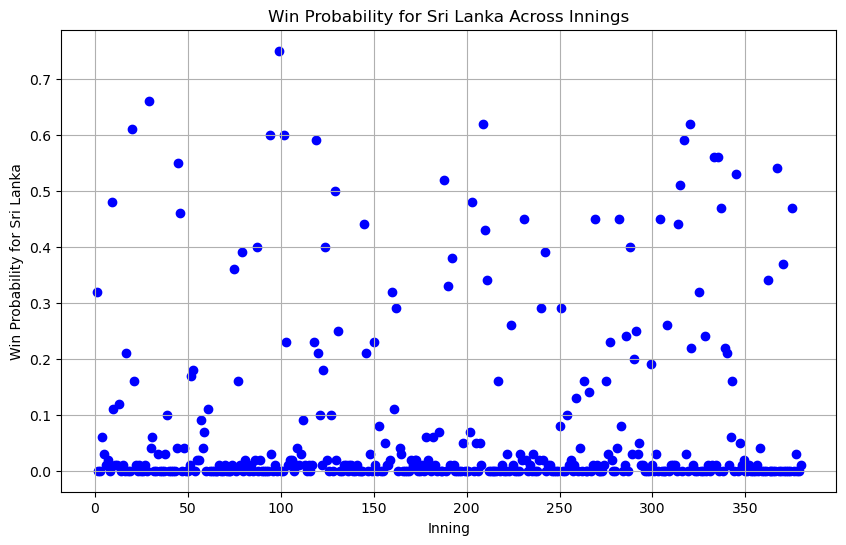

In [3]:
import matplotlib.pyplot as plt

# Plot win probabilities for Sri Lanka across innings
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(win_probabilities) + 1), win_probabilities, color='blue')
plt.xlabel('Inning')
plt.ylabel('Win Probability for Sri Lanka')
plt.title('Win Probability for Sri Lanka Across Innings')
plt.grid(True)
plt.show()


In [5]:
# Select numeric columns for correlation calculation
numeric_columns = inning_df.select_dtypes(include=['number'])

# Calculate Pearson correlation coefficients
correlation_matrix = numeric_columns.corr()

# Display correlations with the target variable (winning team)
winning_team_correlation = correlation_matrix['target'].drop('target')  # Drop the target variable itself
print("Correlation with Winning Team:")
print(winning_team_correlation)


Correlation with Winning Team:
total_runs        0.002165
wickets_fallen    0.049430
overs             0.049430
Name: target, dtype: float64
